<a href="https://colab.research.google.com/github/M-Borsuk/MIRSpectraClassification/blob/main/MIRMeatsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Read the original paper about this dataset!**

[Mid-infrared spectroscopy and authenticity problems in selected meats: a feasibility study](https://www.sciencedirect.com/science/article/abs/pii/S0308814696002890?via%3Dihub)

O. Al-Jowder, E.K. Kemsley, R.H. Wilson,
Mid-infrared spectroscopy and authenticity problems in selected meats: a feasibility study,
Food Chemistry,
Volume 59, Issue 2,
1997,
Pages 195-201,
ISSN 0308-8146



# **Download the dataset**
https://csr.quadram.ac.uk/example-datasets-for-download/

# **General Imports**

In [25]:
!pip install plotly
!pip install xgboost

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score
import warnings
import statsmodels.api as sm
import pickle
warnings.filterwarnings("ignore")

In [27]:
#For the jupyterLab
pio.renderers.default = "notebook_connected"
#For google colab
#pio.renderers.default = "colab"

In [28]:
sns.set("paper","ticks")
sns.color_palette("tab10")
rcParams['figure.figsize'] = 16,8

In [29]:
df = pd.read_csv("/content/drive/MyDrive/MIRFreshMeats.csv")

In [30]:
df.head()

,Wavenumbers,FreshChicken_SupplierA_Sample1_RunA,FreshChicken_SupplierA_Sample1_RunB,FreshChicken_SupplierA_Sample2_RunA,FreshChicken_SupplierA_Sample2_RunB,FreshChicken_SupplierA_Sample3_RunA,FreshChicken_SupplierA_Sample3_RunB,FreshChicken_SupplierA_Sample4_RunA,FreshChicken_SupplierA_Sample4_RunB,FreshChicken_SupplierA_Sample5_RunA,FreshChicken_SupplierA_Sample5_RunB,FreshChicken_SupplierB_Sample1_RunA,FreshChicken_SupplierB_Sample1_RunB,FreshChicken_SupplierB_Sample2_RunA,FreshChicken_SupplierB_Sample2_RunB,FreshChicken_SupplierB_Sample3_RunA,FreshChicken_SupplierB_Sample3_RunB,FreshChicken_SupplierB_Sample4_RunA,FreshChicken_SupplierB_Sample4_RunB,FreshChicken_SupplierB_Sample5_RunA,FreshChicken_SupplierB_Sample5_RunB,FreshChicken_SupplierC_Sample1_RunA,FreshChicken_SupplierC_Sample1_RunB,FreshChicken_SupplierC_Sample2_RunA,FreshChicken_SupplierC_Sample2_RunB,FreshChicken_SupplierC_Sample3_RunA,FreshChicken_SupplierC_Sample3_RunB,FreshChicken_SupplierC_Sample4_RunA,FreshChicken_SupplierC_Sample4_RunB,FreshChicken_SupplierC_Sample5_RunA,FreshChicken_SupplierC_Sample5_RunB,FreshChicken_SupplierD_Sample1_RunA,FreshChicken_SupplierD_Sample1_RunB,FreshChicken_SupplierD_Sample2_RunA,FreshChicken_SupplierD_Sample2_RunB,FreshChicken_SupplierD_Sample3_RunA,FreshChicken_SupplierD_Sample3_RunB,FreshChicken_SupplierD_Sample4_RunA,FreshChicken_SupplierD_Sample4_RunB,FreshChicken_SupplierD_Sample5_RunA,...,FreshTurkey_SupplierE_Sample10_RunA,FreshTurkey_SupplierE_Sample10_RunB,FreshTurkey_SupplierE_Sample11_RunA,FreshTurkey_SupplierE_Sample11_RunB,FreshTurkey_SupplierE_Sample12_RunA,FreshTurkey_SupplierE_Sample12_RunB,FreshTurkey_SupplierE_Sample13_RunA,FreshTurkey_SupplierE_Sample13_RunB,FreshTurkey_SupplierE_Sample14_RunA,FreshTurkey_SupplierE_Sample14_RunB,FreshTurkey_SupplierE_Sample15_RunA,FreshTurkey_SupplierE_Sample15_RunB,FreshTurkey_SupplierE_Sample16_RunA,FreshTurkey_SupplierE_Sample16_RunB,FreshTurkey_SupplierE_Sample17_RunA,FreshTurkey_SupplierE_Sample17_RunB,FreshTurkey_SupplierE_Sample18_RunA,FreshTurkey_SupplierE_Sample18_RunB,FreshTurkey_SupplierE_Sample19_RunA,FreshTurkey_SupplierE_Sample19_RunB,FreshTurkey_SupplierE_Sample1_RunA,FreshTurkey_SupplierE_Sample1_RunB,FreshTurkey_SupplierE_Sample20_RunA,FreshTurkey_SupplierE_Sample20_RunB,FreshTurkey_SupplierE_Sample2_RunA,FreshTurkey_SupplierE_Sample2_RunB,FreshTurkey_SupplierE_Sample3_RunA,FreshTurkey_SupplierE_Sample3_RunB,FreshTurkey_SupplierE_Sample4_RunA,FreshTurkey_SupplierE_Sample4_RunB,FreshTurkey_SupplierE_Sample5_RunA,FreshTurkey_SupplierE_Sample5_RunB,FreshTurkey_SupplierE_Sample6_RunA,FreshTurkey_SupplierE_Sample6_RunB,FreshTurkey_SupplierE_Sample7_RunA,FreshTurkey_SupplierE_Sample7_RunB,FreshTurkey_SupplierE_Sample8_RunA,FreshTurkey_SupplierE_Sample8_RunB,FreshTurkey_SupplierE_Sample9_RunA,FreshTurkey_SupplierE_Sample9_RunB
0,1005.3495,0.549877,0.566602,0.553335,0.548296,0.551651,0.557280,0.553780,0.552251,0.561114,0.549241,0.547157,0.558213,0.560624,0.566026,0.543528,0.553830,0.546035,0.550592,0.559559,0.553924,0.550099,0.548767,0.559127,0.561291,0.554587,0.556771,0.550815,0.560347,0.559110,0.562103,0.547920,0.551141,0.546862,0.553220,0.556131,0.553550,0.562511,0.557949,0.552925,...,0.536833,0.517938,0.514908,0.526969,0.539373,0.509085,0.522777,0.539177,0.538416,0.524857,0.535587,0.539120,0.533032,0.539751,0.535341,0.533615,0.535239,0.529327,0.529109,0.528056,0.513014,0.534334,0.527977,0.521374,0.526067,0.549928,0.527569,0.495946,0.530926,0.524122,0.532547,0.536945,0.511146,0.543811,0.534511,0.501346,0.551161,0.538457,0.534765,0.534360
1,1007.2790,0.547642,0.564157,0.551368,0.545831,0.549111,0.554837,0.551598,0.549755,0.559628,0.547029,0.544240,0.555828,0.558432,0.563840,0.541443,0.551488,0.543740,0.547846,0.556786,0.552096,0.547743,0.546278,0.557202,0.558664,0.552816,0.554540,0.549334,0.557663,0.557237,0.560134,0.545508,0.548886,0.544744,0.550875,0.554411,0.551415,0.560309,0.556225,0.551013,...,0.534695,0.515954,0.512855,0.524588,0.537783,0.506544,0.520685,

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448 entries, 0 to 447
Columns: 121 entries, Wavenumbers to FreshTurkey_SupplierE_Sample9_RunB  
dtypes: float64(121)
memory usage: 423.6 KB


In [32]:
df.describe()

,Wavenumbers,FreshChicken_SupplierA_Sample1_RunA,FreshChicken_SupplierA_Sample1_RunB,FreshChicken_SupplierA_Sample2_RunA,FreshChicken_SupplierA_Sample2_RunB,FreshChicken_SupplierA_Sample3_RunA,FreshChicken_SupplierA_Sample3_RunB,FreshChicken_SupplierA_Sample4_RunA,FreshChicken_SupplierA_Sample4_RunB,FreshChicken_SupplierA_Sample5_RunA,FreshChicken_SupplierA_Sample5_RunB,FreshChicken_SupplierB_Sample1_RunA,FreshChicken_SupplierB_Sample1_RunB,FreshChicken_SupplierB_Sample2_RunA,FreshChicken_SupplierB_Sample2_RunB,FreshChicken_SupplierB_Sample3_RunA,FreshChicken_SupplierB_Sample3_RunB,FreshChicken_SupplierB_Sample4_RunA,FreshChicken_SupplierB_Sample4_RunB,FreshChicken_SupplierB_Sample5_RunA,FreshChicken_SupplierB_Sample5_RunB,FreshChicken_SupplierC_Sample1_RunA,FreshChicken_SupplierC_Sample1_RunB,FreshChicken_SupplierC_Sample2_RunA,FreshChicken_SupplierC_Sample2_RunB,FreshChicken_SupplierC_Sample3_RunA,FreshChicken_SupplierC_Sample3_RunB,FreshChicken_SupplierC_Sample4_RunA,FreshChicken_SupplierC_Sample4_RunB,FreshChicken_SupplierC_Sample5_RunA,FreshChicken_SupplierC_Sample5_RunB,FreshChicken_SupplierD_Sample1_RunA,FreshChicken_SupplierD_Sample1_RunB,FreshChicken_SupplierD_Sample2_RunA,FreshChicken_SupplierD_Sample2_RunB,FreshChicken_SupplierD_Sample3_RunA,FreshChicken_SupplierD_Sample3_RunB,FreshChicken_SupplierD_Sample4_RunA,FreshChicken_SupplierD_Sample4_RunB,FreshChicken_SupplierD_Sample5_RunA,...,FreshTurkey_SupplierE_Sample10_RunA,FreshTurkey_SupplierE_Sample10_RunB,FreshTurkey_SupplierE_Sample11_RunA,FreshTurkey_SupplierE_Sample11_RunB,FreshTurkey_SupplierE_Sample12_RunA,FreshTurkey_SupplierE_Sample12_RunB,FreshTurkey_SupplierE_Sample13_RunA,FreshTurkey_SupplierE_Sample13_RunB,FreshTurkey_SupplierE_Sample14_RunA,FreshTurkey_SupplierE_Sample14_RunB,FreshTurkey_SupplierE_Sample15_RunA,FreshTurkey_SupplierE_Sample15_RunB,FreshTurkey_SupplierE_Sample16_RunA,FreshTurkey_SupplierE_Sample16_RunB,FreshTurkey_SupplierE_Sample17_RunA,FreshTurkey_SupplierE_Sample17_RunB,FreshTurkey_SupplierE_Sample18_RunA,FreshTurkey_SupplierE_Sample18_RunB,FreshTurkey_SupplierE_Sample19_RunA,FreshTurkey_SupplierE_Sample19_RunB,FreshTurkey_SupplierE_Sample1_RunA,FreshTurkey_SupplierE_Sample1_RunB,FreshTurkey_SupplierE_Sample20_RunA,FreshTurkey_SupplierE_Sample20_RunB,FreshTurkey_SupplierE_Sample2_RunA,FreshTurkey_SupplierE_Sample2_RunB,FreshTurkey_SupplierE_Sample3_RunA,FreshTurkey_SupplierE_Sample3_RunB,FreshTurkey_SupplierE_Sample4_RunA,FreshTurkey_SupplierE_Sample4_RunB,FreshTurkey_SupplierE_Sample5_RunA,FreshTurkey_SupplierE_Sample5_RunB,FreshTurkey_SupplierE_Sample6_RunA,FreshTurkey_SupplierE_Sample6_RunB,FreshTurkey_SupplierE_Sample7_RunA,FreshTurkey_SupplierE_Sample7_RunB,FreshTurkey_SupplierE_Sample8_RunA,FreshTurkey_SupplierE_Sample8_RunB,FreshTurkey_SupplierE_Sample9_RunA,FreshTurkey_SupplierE_Sample9_RunB
count,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,...,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000
mean,1436.606567,0.639409,0.653977,0.638609,0.632492,0.634159,0.638489,0.633013,0.631701,0.627532,0.616325,0.621017,0.629452,0.644571,0.650837,0.621619,0.630557,0.619272,0.622682,0.637129,0.630859,0.629287,0.626518,0.641915,0.641574,0.632714,0.634328,0.629290,0.63683

In [33]:
df.shape

(448, 121)

# **Data Cleaning**

In [34]:
print("There are{}columns with missing values".format(" NO " if df.isna().sum().reset_index()["index"][df.isna().sum().reset_index().iloc[:,1] !=0].shape[0] == 0 else ""))

There are NO columns with missing values


In [35]:
df.columns

Index(['Wavenumbers', 'FreshChicken_SupplierA_Sample1_RunA  ',
       'FreshChicken_SupplierA_Sample1_RunB  ',
       'FreshChicken_SupplierA_Sample2_RunA  ',
       'FreshChicken_SupplierA_Sample2_RunB  ',
       'FreshChicken_SupplierA_Sample3_RunA  ',
       'FreshChicken_SupplierA_Sample3_RunB  ',
       'FreshChicken_SupplierA_Sample4_RunA  ',
       'FreshChicken_SupplierA_Sample4_RunB  ',
       'FreshChicken_SupplierA_Sample5_RunA  ',
       ...
       'FreshTurkey_SupplierE_Sample5_RunA  ',
       'FreshTurkey_SupplierE_Sample5_RunB  ',
       'FreshTurkey_SupplierE_Sample6_RunA  ',
       'FreshTurkey_SupplierE_Sample6_RunB  ',
       'FreshTurkey_SupplierE_Sample7_RunA  ',
       'FreshTurkey_SupplierE_Sample7_RunB  ',
       'FreshTurkey_SupplierE_Sample8_RunA  ',
       'FreshTurkey_SupplierE_Sample8_RunB  ',
       'FreshTurkey_SupplierE_Sample9_RunA  ',
       'FreshTurkey_SupplierE_Sample9_RunB  '],
      dtype='object', length=121)

In [36]:
df = df.T

In [37]:
df = df.reset_index()

In [38]:
df.columns = df.loc[0,:]

In [39]:
df["Label"] = df["Wavenumbers"].apply(lambda x: x.split("_")[0][5:])

In [40]:
df = df.drop(columns="Wavenumbers")
df = df.drop(index = 0)

In [41]:
df.shape

(120, 449)

In [42]:
df.columns

Index([         1005.3495,           1007.279,          1009.2085,
                 1011.138,          1013.0675,           1014.997,
                1016.9265, 1018.8560000000001,          1020.7855,
                 1022.715,
       ...
       1852.4279999999999,          1854.3575,           1856.287,
                1858.2165,           1860.146,          1862.0755,
                 1864.005,          1865.9345,           1867.864,
                  'Label'],
      dtype='object', name=0, length=449)

# **EDA**

In [43]:
def plot_countplot(df,x):
  sns.countplot(x=x,data = df)
  plt.title("Distribution of {} values".format(x))
  plt.show()

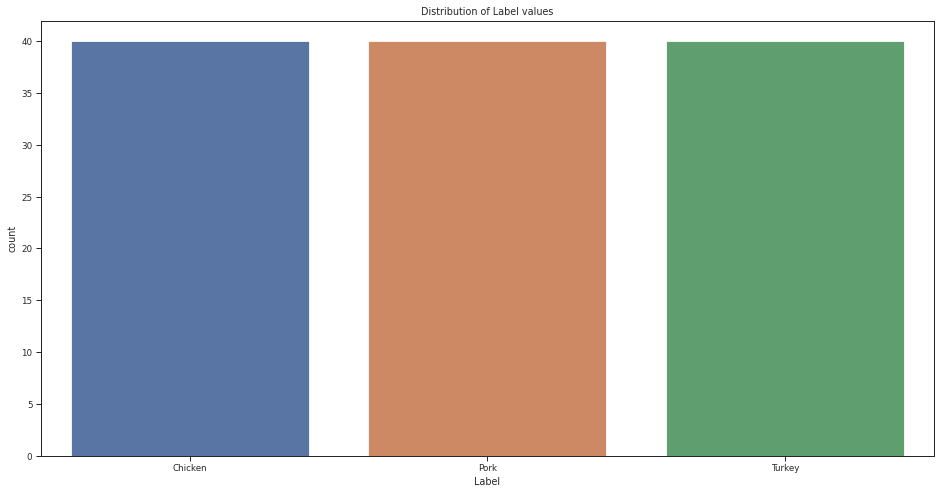

In [44]:
plot_countplot(df,"Label")

In [45]:
def plot_line(x,*y,title,color=None):
  fig = go.Figure()
  colors = ["red","blue","green","darkviolet","orange","brown","gold"]
  for i,data in enumerate(y):
    fig.add_trace(go.Scatter(x=x, y=data[0],
                    line=dict(color=colors[i], width=4),
                    name=data[1]))
  fig.update_layout(title=title)
  fig.show()

In [46]:
temp = df.groupby("Label").mean().reset_index()
plot_line(temp.columns[1:],(temp[temp["Label"] == "Chicken"].iloc[:,1:].values[0],"Chicken"),title="FTIR Spectra of chicken meat")

In [47]:
temp = df.groupby("Label").mean().reset_index()
plot_line(temp.columns[1:],(temp[temp["Label"] == "Pork"].iloc[:,1:].values[0],"Pork"),title = "FTIR Spectra of pork meat")

In [48]:
temp = df.groupby("Label").mean().reset_index()
plot_line(temp.columns[1:],(temp[temp["Label"] == "Turkey"].iloc[:,1:].values[0],"Turkey"),title = "FTIR Spectra of turkey meat")

In [49]:
plot_line(temp.columns[1:],(temp[temp["Label"] == "Turkey"].iloc[:,1:].values[0],"Turkey"),(temp[temp["Label"] == "Chicken"].iloc[:,1:].values[0],"Chicken"),(temp[temp["Label"] == "Pork"].iloc[:,1:].values[0],"Pork"),title = "FTIR Spectra of every type of meat")

In [50]:
le = LabelEncoder()
df["Label"] = le.fit_transform(df["Label"])

In [51]:
df["Label"].unique()

array([0, 1, 2])

In [52]:
X,y = df.iloc[:,:-1],df.iloc[:,-1]

In [53]:
X.shape

(120, 448)

In [54]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# **PCA**

In [55]:
pca = PCA(.9)

In [56]:
X = pca.fit_transform(X)

In [57]:
X.shape

(120, 2)

In [58]:
y.shape

(120,)

In [59]:
principalDf = pd.DataFrame(data = X
             , columns = ['PC1', 'PC2'])

In [60]:
principalDf.head()

,PC1,PC2
0,25.068000,7.629409
1,40.543896,2.970833
2,25.863574,3.472475
3,18.712381,7.271332
4,21.806974,2.818770


In [61]:
def plot_scatter(x,y,title,color = None):
  fig = px.scatter(x=x, y=y, color=color,title=title)
  fig.show()

In [62]:
plot_scatter(principalDf["PC1"],principalDf["PC2"],color=y,title="PCA visualisation")

In [63]:
X_train,X_test,y_train,y_test = train_test_split(principalDf,y,test_size = 0.2)

In [64]:
X_train.shape

(96, 2)

In [65]:
X_test.shape

(24, 2)

In [66]:
y_train.shape

(96,)

In [67]:
def display_scores(scores):
  print("Scores:", scores)
  print("Average:", scores.mean())
  print("Standard deviation:", scores.std())

In [68]:
def plot_cm(cm):
  plt.subplots(figsize=(12, 12))
  sns.heatmap(cm/np.sum(cm),annot=True,fmt=" %")

# **Logisitic Regression**

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr_model.coef_,lr_model.intercept_

(array([[ 0.37908355,  0.51206049],
        [-0.47469112, -0.94830796],
        [ 0.09560757,  0.43624747]]),
 array([-0.60411264, -1.80377362,  2.40788626]))

In [ ]:
print("Accuracy of the model: {} %".format(np.round(lr_model.score(X_test,y_test)*100,2)))

Accuracy of the model: 95.83 %


In [ ]:
scores = cross_val_score(lr_model, X_train, y_train, cv=10)

In [ ]:
display_scores(scores)

Scores: [1.         0.9        1.         1.         1.         1.
 0.88888889 0.88888889 0.88888889 0.77777778]
Average: 0.9344444444444445
Standard deviation: 0.0731057073315377


In [ ]:
y_pred = lr_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.88      0.93         8
           2       0.83      1.00      0.91         5

    accuracy                           0.96        24
   macro avg       0.94      0.96      0.95        24
weighted avg       0.97      0.96      0.96        24



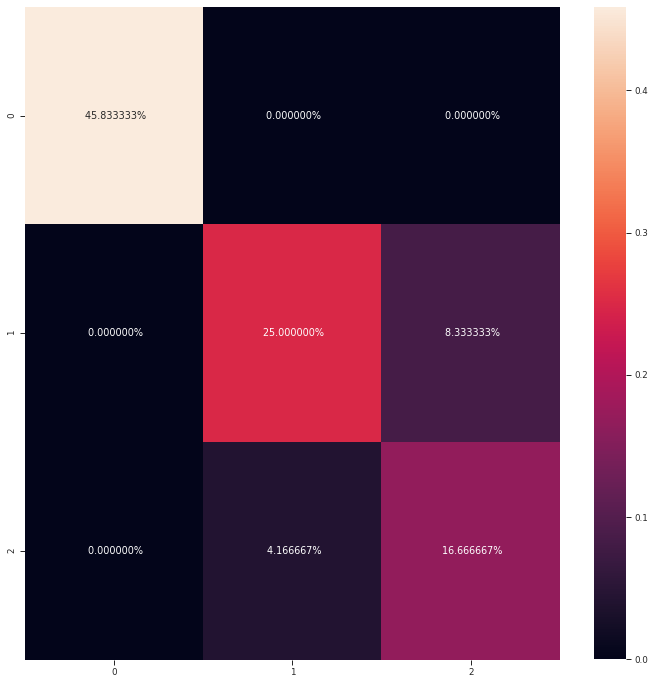

In [ ]:
plot_cm(confusion_matrix(y_test,y_pred))

In [ ]:
pickle.dump(lr_model,open('/content/drive/MyDrive/lr_model.pickle', 'wb'))

# **Random Forest**

In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print("Accuracy of the model: {} %".format(np.round(rf_model.score(X_test,y_test)*100,2)))

Accuracy of the model: 87.5 %


In [ ]:
scores = cross_val_score(rf_model, X_train, y_train, cv=10)

In [ ]:
display_scores(scores)

Scores: [0.9        0.9        1.         0.8        1.         1.
 0.88888889 0.88888889 0.88888889 0.77777778]
Average: 0.9044444444444446
Standard deviation: 0.07423685817106696


In [ ]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.86      0.75      0.80         8
           2       0.67      0.80      0.73         5

    accuracy                           0.88        24
   macro avg       0.84      0.85      0.84        24
weighted avg       0.88      0.88      0.88        24



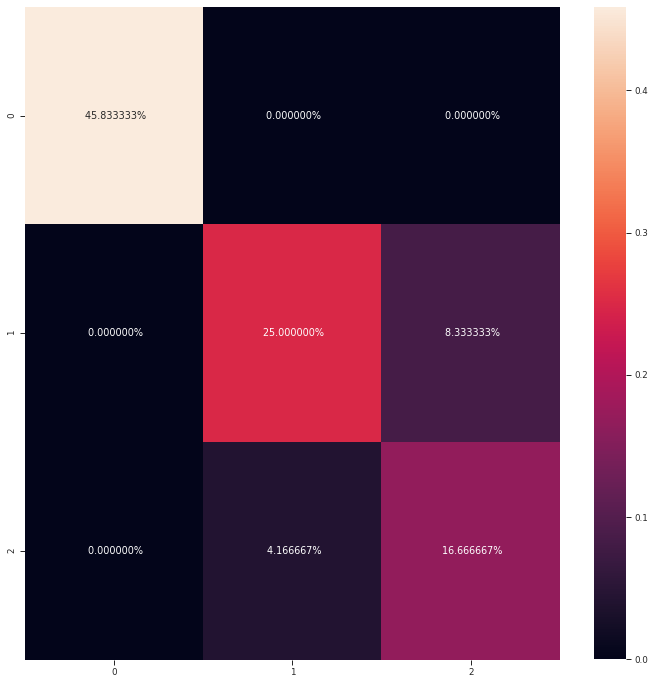

In [ ]:
plot_cm(confusion_matrix(y_test,y_pred))

In [ ]:
pickle.dump(rf_model,open('/content/drive/MyDrive/rf_model.pickle', 'wb'))

# **Support vector machine**

In [ ]:
svc_model = SVC()
svc_model.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
print("Accuracy of the model: {} %".format(np.round(svc_model.score(X_test,y_test)*100,2)))

Accuracy of the model: 91.67 %


In [ ]:
scores = cross_val_score(svc_model, X_train, y_train, cv=10)

In [ ]:
display_scores(scores)

Scores: [1.         0.8        1.         1.         1.         1.
 0.88888889 0.88888889 0.88888889 0.66666667]
Average: 0.9133333333333333
Standard deviation: 0.10631887745693944


In [ ]:
y_pred = svc_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.75      0.86         8
           2       0.71      1.00      0.83         5

    accuracy                           0.92        24
   macro avg       0.90      0.92      0.90        24
weighted avg       0.94      0.92      0.92        24



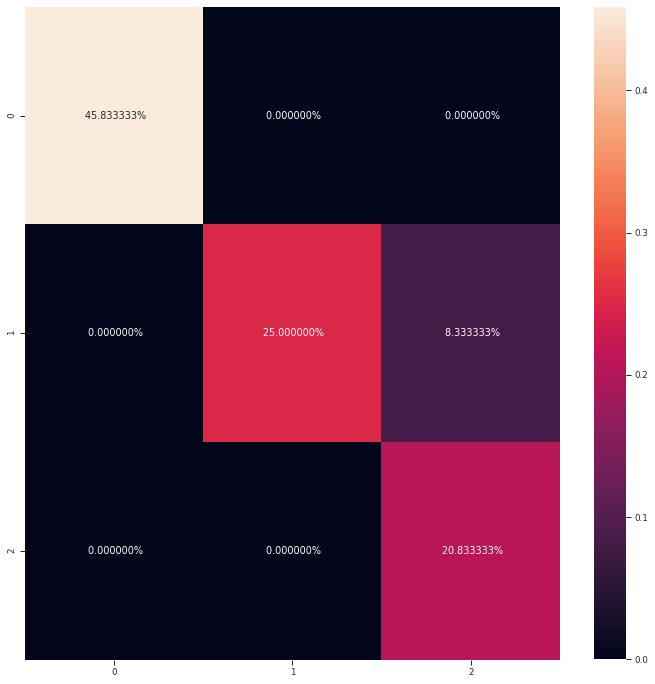

In [ ]:
plot_cm(confusion_matrix(y_test,y_pred))

In [ ]:
pickle.dump(svc_model,open('/content/drive/MyDrive/svc_model.pickle', 'wb'))